In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


In [4]:
##!!1. Establish a CNN Architecture (Based on Pytorch Library) to classify MINST Dataset, bydefining layers (Convolution, pooling, fully connect layer), the hyper-parameters (Kernels,Padding , stride, optimizers, regularization, etc) and running the model in GPU mode.
import random
import numpy as np 
import pandas as pd 
import os
import struct
%matplotlib inline
import random
import matplotlib.pyplot as plt
from array import array
from os.path  import join
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath, test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)
    def display_image(self, images, labels, index):
        if index < 0 or index >= len(images):
            print("Index out of range.")
            return

        plt.figure(figsize=(2,2))
        plt.imshow(images[index], cmap='gray')
        plt.title(f"Label: {labels[index]}")
        plt.show()
from os.path  import join
input_path = '/kaggle/input/mnist-dataset'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()



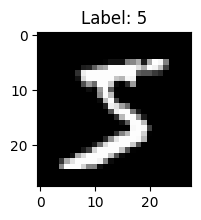

In [5]:
mnist_dataloader.display_image(x_train, y_train, 0)


In [6]:
##!!simple cnn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 10

# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# Evaluation on test data
model.eval()
with torch.no_grad():
    x_test_tensor = x_test_tensor.to(device)
    outputs = model(x_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')


/tmp/ipykernel_47/3914452158.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)


Epoch 1/10, Loss: 0.03179405257105827
Epoch 2/10, Loss: 0.006931411102414131
Epoch 3/10, Loss: 0.00833976175636053
Epoch 4/10, Loss: 0.06867944449186325
Epoch 5/10, Loss: 4.388837260194123e-05
Epoch 6/10, Loss: 0.00047631392953917384
Epoch 7/10, Loss: 0.00033275820896960795
Epoch 8/10, Loss: 0.0005501678679138422
Epoch 9/10, Loss: 0.0024941531009972095
Epoch 10/10, Loss: 0.013781704008579254
Test Accuracy: 98.70%


In [7]:
##!! ##!!same thing with Faster R-CNN.
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_classification

# Create a synthetic dataset for object detection
X, y = make_classification(n_samples=100, n_features=20, n_classes=2, random_state=42)
images = X.reshape(-1, 1, 5, 4)  # Reshape to represent images
labels = y

# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(images, dtype=torch.float32)
y_train_tensor = torch.tensor(labels, dtype=torch.long)

# Create DataLoader
class DetectionDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], {'labels': self.labels[idx]}

train_dataset = DetectionDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Define the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the input layer to accept single-channel images
model.backbone.body.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Modify the output layer for classification
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, 2)  # 2 classes for binary classification

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyperparameters
learning_rate = 0.001
epochs = 5

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    for images, targets in train_loader:
        images, targets = images.to(device), {'labels': targets['labels'].to(device)}
        
        optimizer.zero_grad()
        outputs = model(images, targets)
        loss = sum(loss for loss in outputs.values())
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# Evaluation on test data (similar to object detection)
model.eval()
with torch.no_grad():
    x_test_tensor = x_train_tensor.to(device)
    outputs = model(x_test_tensor)
    _, predicted = torch.max(outputs[0]['labels'], 1)
    accuracy = (predicted == y_train_tensor).sum().item() / len(y_train_tensor)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

In [8]:
## By using retrained models (VGG16 and AlexNet) fine tune your model to the new dataSet,
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split

# Modify this according to your actual dataset loading process
input_path = '/kaggle/input/mnist-dataset'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Convert data to PyTorch tensors
x_train_tensor = torch.Tensor(np.expand_dims(x_train, axis=1)) / 255.0  # Normalize pixel values
y_train_tensor = torch.LongTensor(y_train)

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train_tensor, y_train_tensor, test_size=0.1, random_state=42)

# Define VGG16 model
model = models.vgg16(pretrained=True)
num_classes = 10  # MNIST has 10 classes
model.classifier[6] = nn.Linear(4096, num_classes)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples * 100
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.2f}%')

# Test the model on the test set
test_dataset = TensorDataset(torch.Tensor(np.expand_dims(x_test, axis=1)) / 255.0, torch.LongTensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

test_accuracy = total_correct / total_samples * 100
print(f'Test Accuracy: {test_accuracy:.2f}%')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


URLError: <urlopen error [Errno -3] Temporary failure in name resolution>